# LDDMM vs Metamorphoses
## Bonus Experiment


We start by opening the pictures and preparing all variable we need.
You can use pre-made images, or construct the play exemple from scratch

In [1]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np


import my_toolbox as tb_np
import my_torchbox as tb
import my_bspline as mbs
import vector_field_to_flow as vff
import metamorphosis as mt

# Select gpu or cpu
cuda = torch.cuda.is_available()
device = 'cpu'
if cuda:
    device = torch.device('cuda:0')
   #device = get_freer_gpu()
print('device selected : ',device)

device selected :  cuda:0


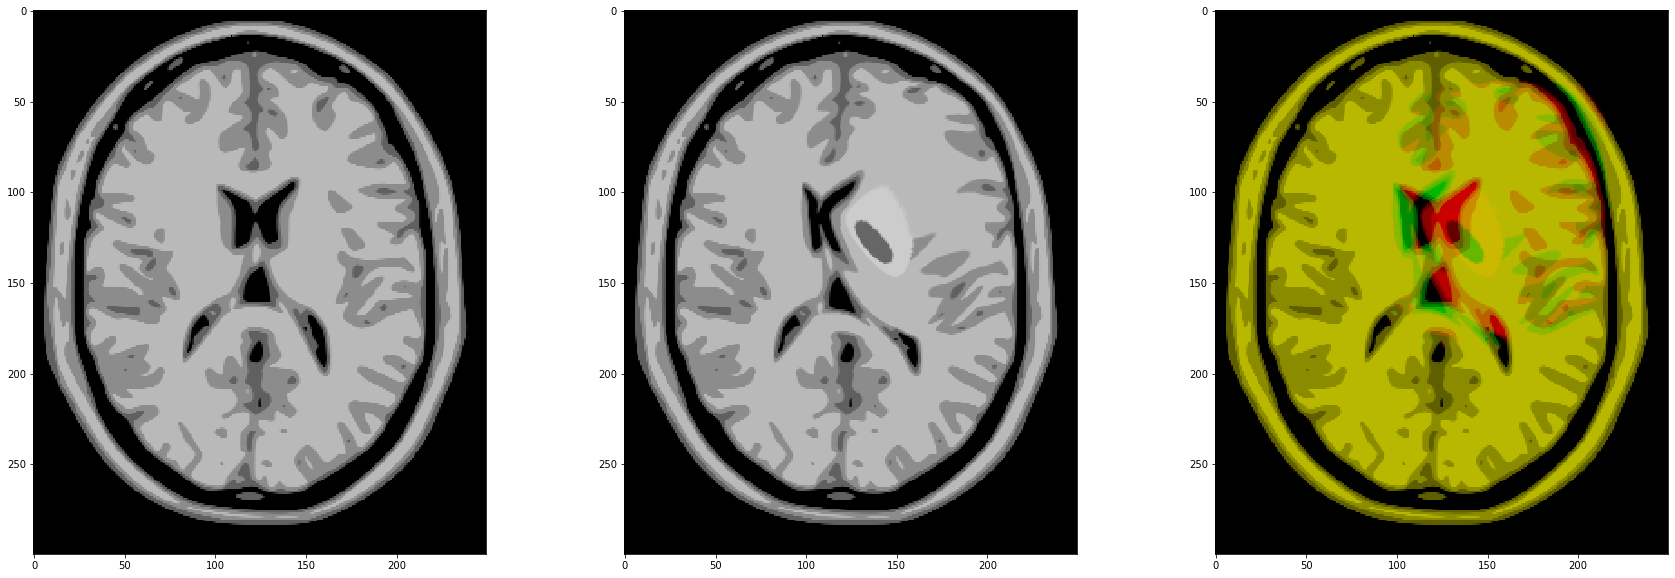

In [2]:
plt.rcParams['figure.figsize'] = [10,20]
size = (300,int((300)*5/6))
S = tb.reg_open('b0',size = size)
T = tb.reg_open('b11',size = size)
# T=T*S.max()
if size is None:
    _,_,H,W = S.shape
    size = (H,W)
else:
    H,W = size

if False:
    sig = 1
    smooth = flt.GaussianBlur2d((sig*6+1,sig*6+1), (sig, sig))
    S = smooth(S)
    T = smooth(T)




plt.rcParams['figure.figsize'] = [30,10]
fig,ax = plt.subplots(1,3)
ax[0].imshow(S[0,0,:,:],cmap='gray',vmin=0,vmax=1)
ax[1].imshow(T[0,0,:,:],cmap='gray',vmin=0,vmax=1)
ax[2].imshow(tb.imCmp(S,T),vmin=0,vmax=1)

If you decide to make make a custom example please follow the next steps


Let's open our "template healthy brain example" which is an healthy brain.

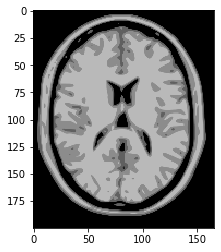

In [2]:
s = 200
size = (s,int(s*5/6))
# size = None
image_kwarg = dict(cmap = 'gray',vmin = 0,vmax = 1)
S = tb.reg_open('b0',size=size)

if size is None:
    _,_,H,W = S.shape
    size = (H,W)
else:
    H,W = size

plt.imshow(S[0,0],**image_kwarg)

We know make grow a cancer into the brain
First we need to place it as a small ball

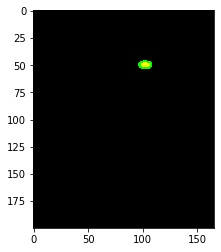

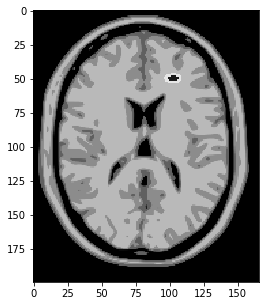

In [3]:
_,_,H,W = S.shape
dx_convention = '2square'
id_grid = tb.make_regular_grid((H,W),dx_convention=dx_convention)

# cancer initialisation
XX , YY = np.meshgrid(range(W),range(H))

# Feel free to play with theses parameters
centre = (.62,.25)
necrosis_size = (.025,.01) # (height,width)
edema_size = (.04,.02) # (height,width)

bool_necrosis = tb_np.full_ellipse(XX/(W-1),YY/(H-1),necrosis_size[0],necrosis_size[1],centre)
bool_eudema = tb_np.full_ellipse(XX/(W-1),YY/(H-1),edema_size[0],edema_size[1],centre)

plt.imshow(tb_np.imCmp(bool_eudema,bool_necrosis))

S_np = S[0,0].clone().numpy()
S_np[bool_eudema] = .9
S_np[bool_necrosis] = .1
# bool_ellispe = full_ellipse(id_grid[0,:,:,0],id_grid[0,:,:,1],10,10,(150,320))
plt.rcParams['figure.figsize'] = [5,5]
plt.figure()
plt.imshow(S_np,**image_kwarg)

Let know construct a field to make 'grow' the cancer.

torch.Size([1, 200, 166, 2])


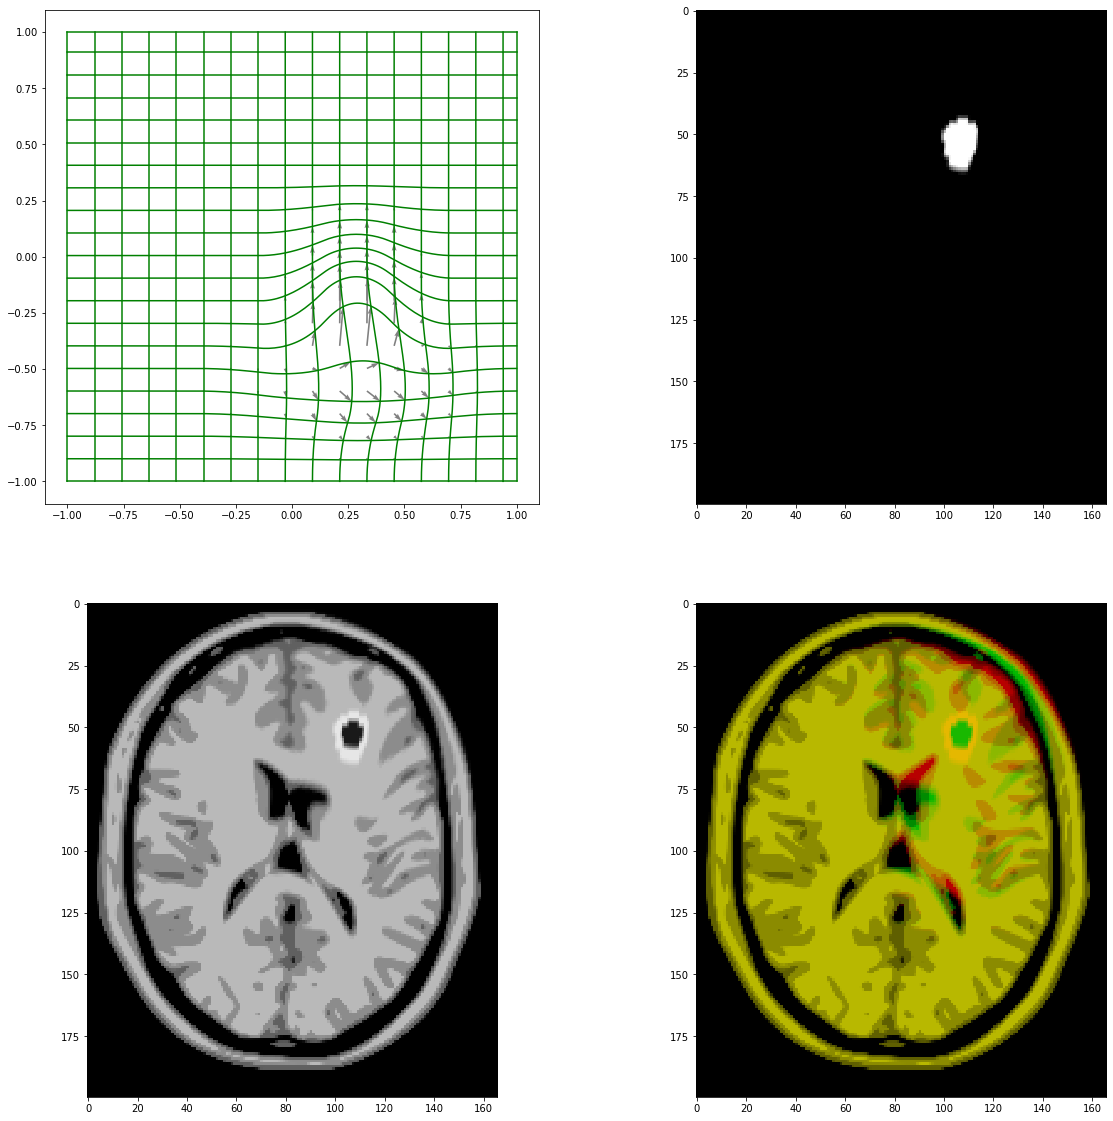

In [4]:
"""
cms = torch.tensor([
    [
        [0.,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,-.05,  -.2,  -.05,  0,  0,  0,  0],
        [0,  0,  0,  -.25,  0,  0,  0,  0,  0],
        [0,  0,  .05,  .1,  .05,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0]
    ],
    [
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  -.05,  0, .05,  0,  0,  0,  0],
        [0,  0, -.2,  .25, .2,  0,  0,  0,  0],
        [0,  0,  -.05,  0,.05,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0]
    ]
    ]
)
"""
cms = torch.tensor([
    [
        [0.,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  .2,  0,  0,  0,  0,  0,  0],
        [0,  0,  .1,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0]
    ],
    [
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,-.1,  0,  0,  0,  0,  0,  0],
        [0,  0,-.2,  .75,  .3,  0,  0,  0,  0],
        [0,  0,-.1,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0],
        [0,  0,  0,  0,  0,  0,  0,  0,  0]
    ]
    ]
)

# Building the deformation
# vector field construiction from control matrix cms
field = mbs.field2D_bspline(cms*.5,(W,H),dim_stack=2,degree=(2,2)).unsqueeze(0)
print(field.size())
# Computation of a deformation from the field
fast_exp= vff.FieldIntegrator(method='fast_exp',save = False,dx_convention=dx_convention)
deff_diff = fast_exp(field.clone(),forward= True)
deff_diffor = fast_exp(field.clone(),forward = False)
# S = torch.tensor(S_np)[None,None]
# make the cancer grow
S_deformed = tb.imgDeform(torch.tensor(S_np)[None,None],deff_diffor,dx_convention=dx_convention)

# Let also retrieve a mask for later
mask = tb.imgDeform(torch.tensor(bool_eudema)[None,None].float(),
                    deff_diffor,dx_convention=dx_convention)


plt.rcParams['figure.figsize'] = [20,20]
fig,ax = plt.subplots(2,2)
tb.quiver_plot(deff_diff - id_grid ,
               step=10,ax=ax[0,0],color='gray',dx_convention=dx_convention)
tb.gridDef_plot(deff_diff,
                add_grid=False,step=10,ax=ax[0,0],color='green',dx_convention=dx_convention)
ax[0,1].imshow(mask[0,0],**image_kwarg)

ax[1,0].imshow(S_deformed[0,0],**image_kwarg)

ax[1,1].imshow(tb.imCmp(S,S_deformed))


## LDDMM and Metamorphosis Application


Now let's run the experiments,

The optimisation can take some time depending on the GPU you have, if you want to save some time you can load the initials residuals $z_0$ and use a smaller number of iterations (five will be enough). If you do so, note that you have to load images of the right size (150x150).


In [28]:
id_grid = tb.make_regular_grid(size)
field = id_grid.clone()

residuals_l = torch.zeros(size)
residuals_l.requires_grad = True
residuals_l.to(device)
residuals_m = torch.zeros(size)
residuals_m.requires_grad = True
residuals_m.to(device)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CopyBackwards>)

In [7]:
# If you want to load the residuals,
residuals_l = torch.load('residuals_banks/fileofyourchoosing')
residuals_m = torch.load('residuals_banks/fileofyourchoosing')



Percent: [##########] 100% Done...66667%  
Computation done in :  0:00:53s and 0.387cents
Percent: [##########] 100% Done...99999%  
Computation done in :  0:03:44s and 0.633cents


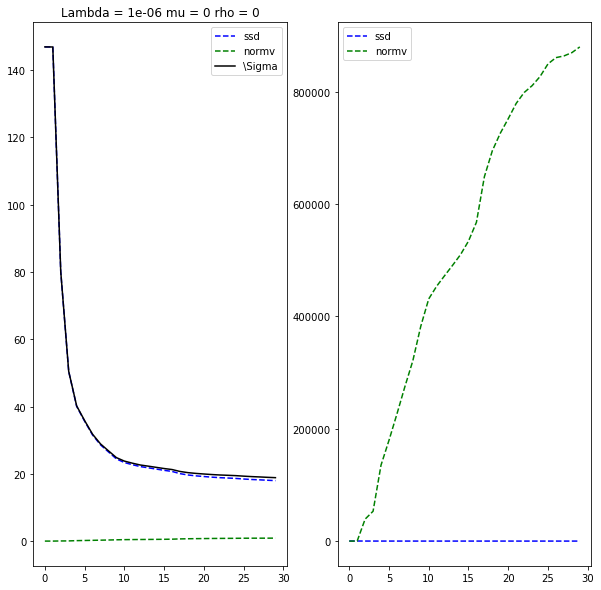

In [29]:
T = S_deformed.clone()
sigma_v = 10 # sigma of the reproducing kernel (the size of the kernel will be 3*sigma_v)
n_step = 10  # the time step will be dt = 1/n_step
# n_iter = 75 # gradient descent iterations.
grad_dt = .1 # gradient descent multiplicator

# LDDMM optimisation
start = time.time()
lamb,mu,rho = (.000001,0,0)
# initilisation of the geodesic shooting method
mp_lddmm = mt.metamorphosis_path(method ='semiLagrangian',
                                 mu=mu,sigma_v=sigma_v,n_step=n_step)
# initialisation of the gradient descent using the geodesic shooting method
mr_lddmm = mt.optimize_geodesicShooting(S,T,mp_lddmm,
                                        dict(lamb=lamb,rho = 0),
                                     optimizer_method='LBFGS_torch')
# optimisation
mr_lddmm.forward(residuals_l,n_iter=30,grad_coef=.1)
end = time.time()
print("Computation done in : ",tb_np.format_time(end - start))
mr_lddmm.plot_cost()

# Metamorphosis optimisation
start = time.time()
lamb,mu,rho = (1e-6,1e-4,5e-1)
mp_meta = mt.metamorphosis_path(method ='semiLagrangian',
                                mu=mu,sigma_v=sigma_v,n_step=n_step)
mr_meta = mt.mr_sl_m = mt.optimize_geodesicShooting(S,T,mp_meta,
                                    dict(lamb=lamb,rho = rho),
                                    optimizer_method='LBFGS_torch')
mr_meta.forward(residuals_m,n_iter=100,grad_coef=.1)
end = time.time()
print("Computation done in : ",tb_np.format_time(end - start))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


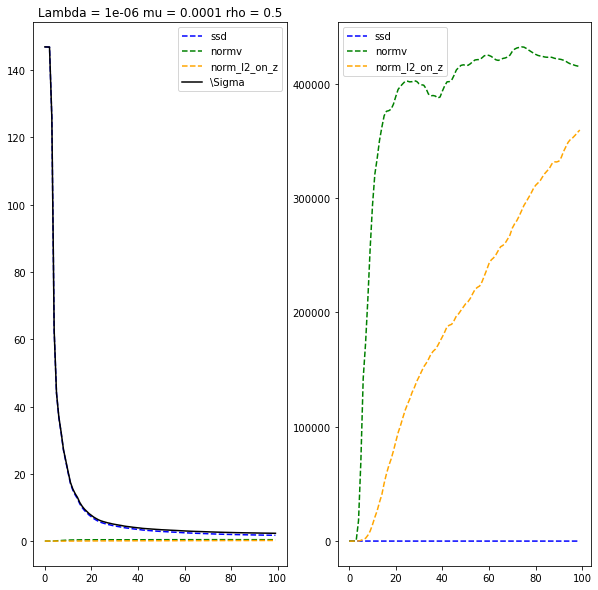

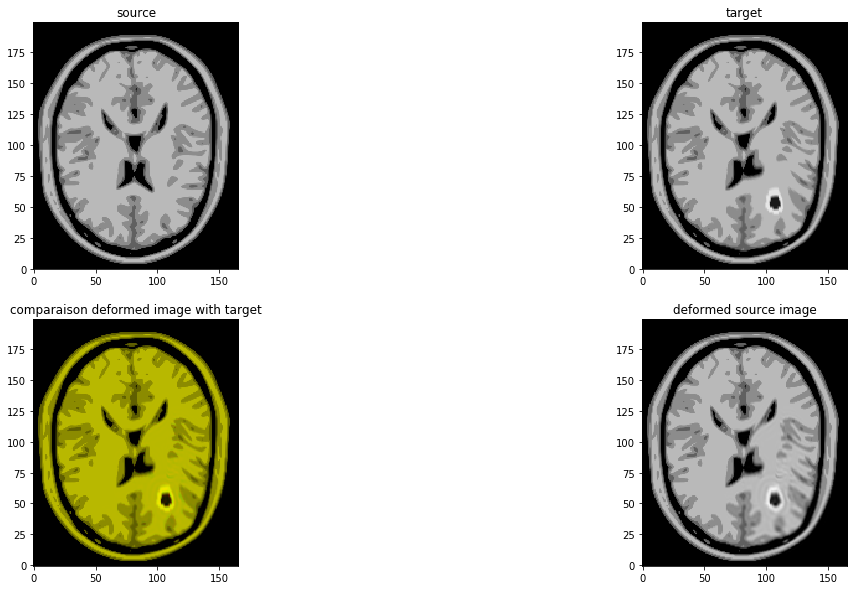

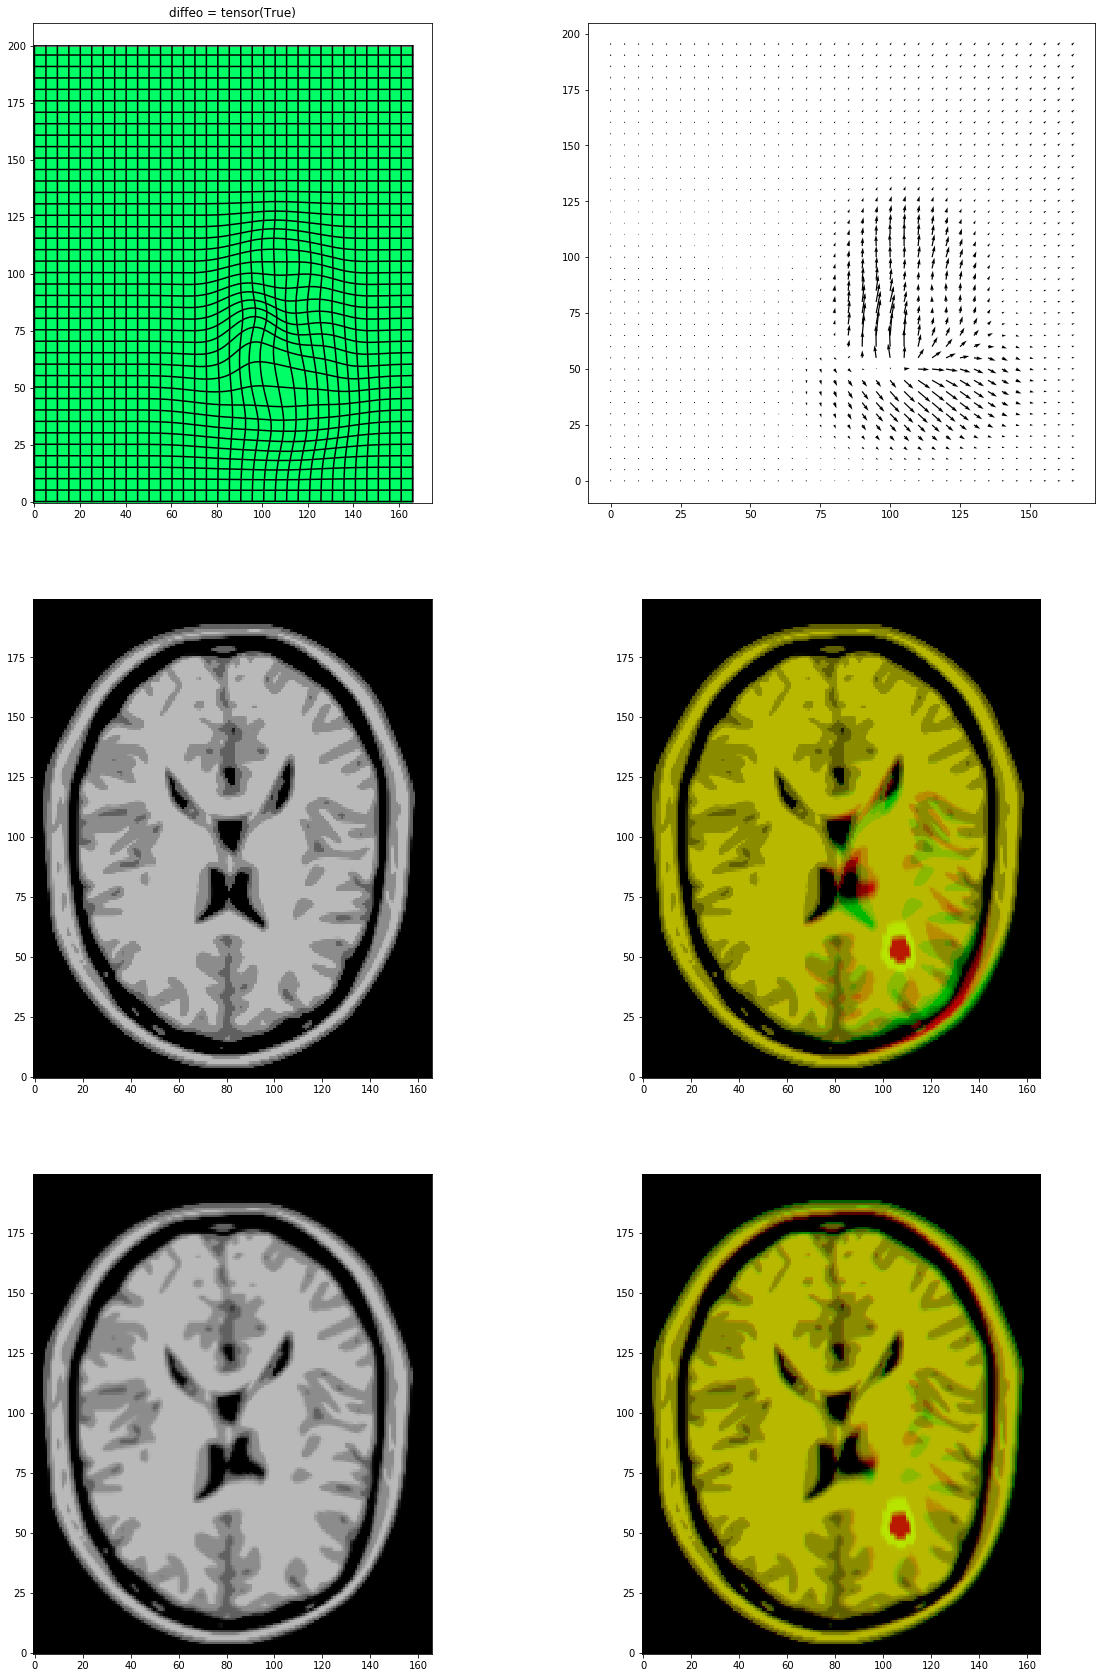

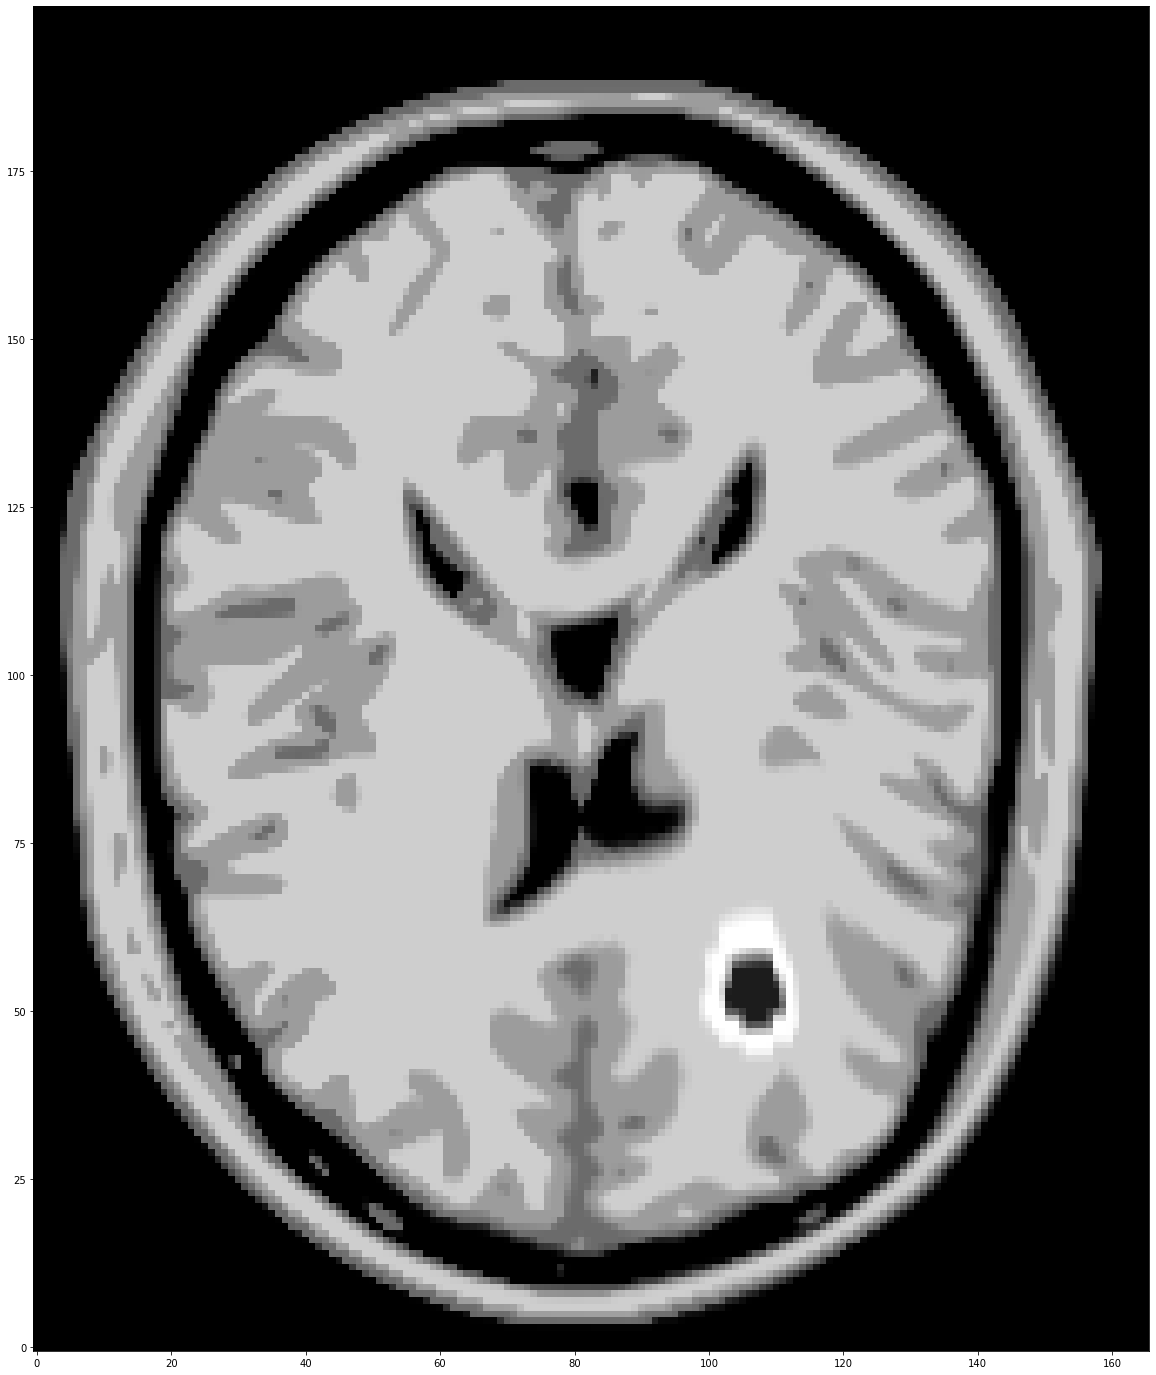

In [30]:
mr_meta.plot()
mr_meta.mp.plot_deform(T)
plt.figure()
plt.imshow(T[0,0],cmap='gray',origin='lower')

We can now save the optimized residuals for further usage

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CopyBackwards>)

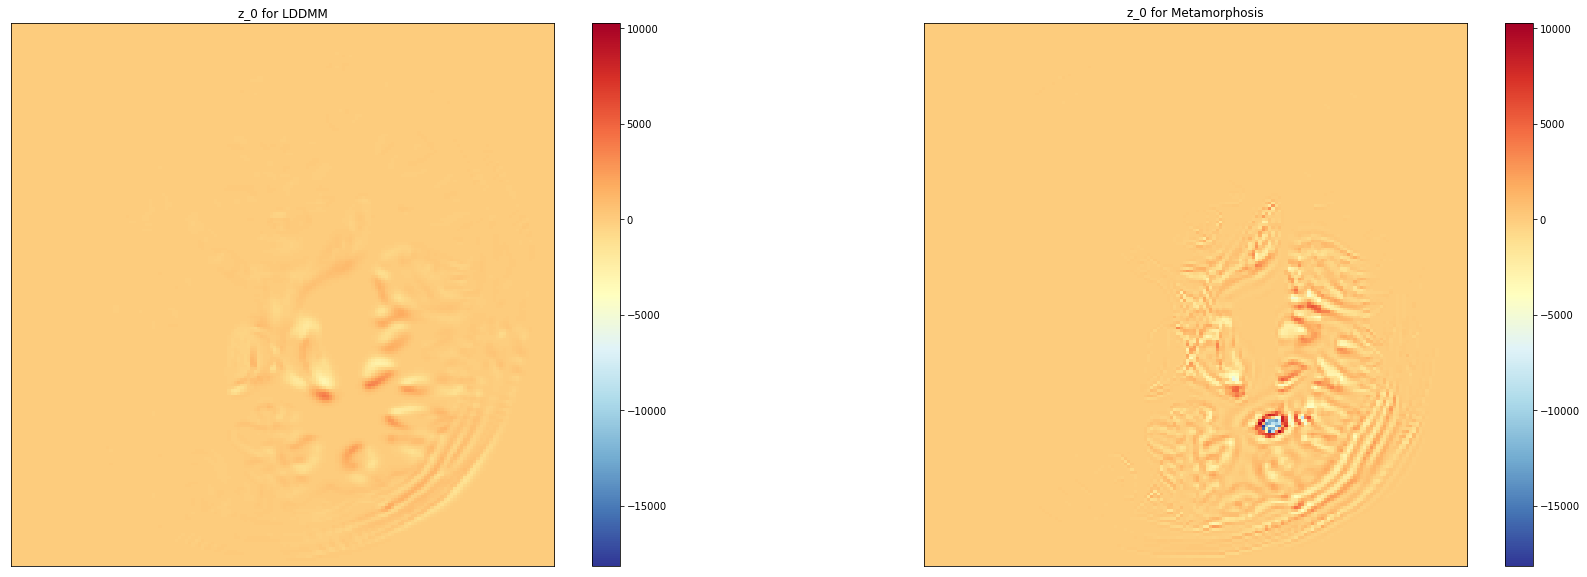

In [31]:
# recovering the optimized residuals.
residuals_l = mr_lddmm.to_analyse[0]
residuals_m = mr_meta.to_analyse[0]

kw_residuals_args = dict(cmap='RdYlBu_r',
                      extent=[-1,1,-1,1],
                      origin='lower',
                      vmin=torch.minimum(residuals_l.min(),residuals_m.min()),
                      vmax=torch.maximum(residuals_l.max(),residuals_m.max()))


# plot
plt.rcParams['figure.figsize'] = [30,10]

fig_r,ax_r = plt.subplots(1,2)
r1 = ax_r[0].imshow(residuals_l.detach(),**kw_residuals_args)
ax_r[0].set_title("z_0 for LDDMM")
fig_r.colorbar(r1,ax= ax_r[0])
r2 = ax_r[1].imshow(residuals_m.detach(),**kw_residuals_args)
ax_r[1].set_title("z_0 for Metamorphosis")
fig_r.colorbar(r2,ax= ax_r[1])
plt.setp(ax_r, xticks=[], yticks=[])

# set back parameters needed for optimisation
residuals_l.requires_grad =True
residuals_l.to(device)
residuals_m.requires_grad =True
residuals_m.to(device)


In [ ]:
torch.save(residuals_l,'residuals_banks/residuals_fig_mu00_lambm6_'+str(size[0]))
torch.save(residuals_l,'residuals_banks/residuals_fig_mu035_lambm6_'+str(size[0]))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


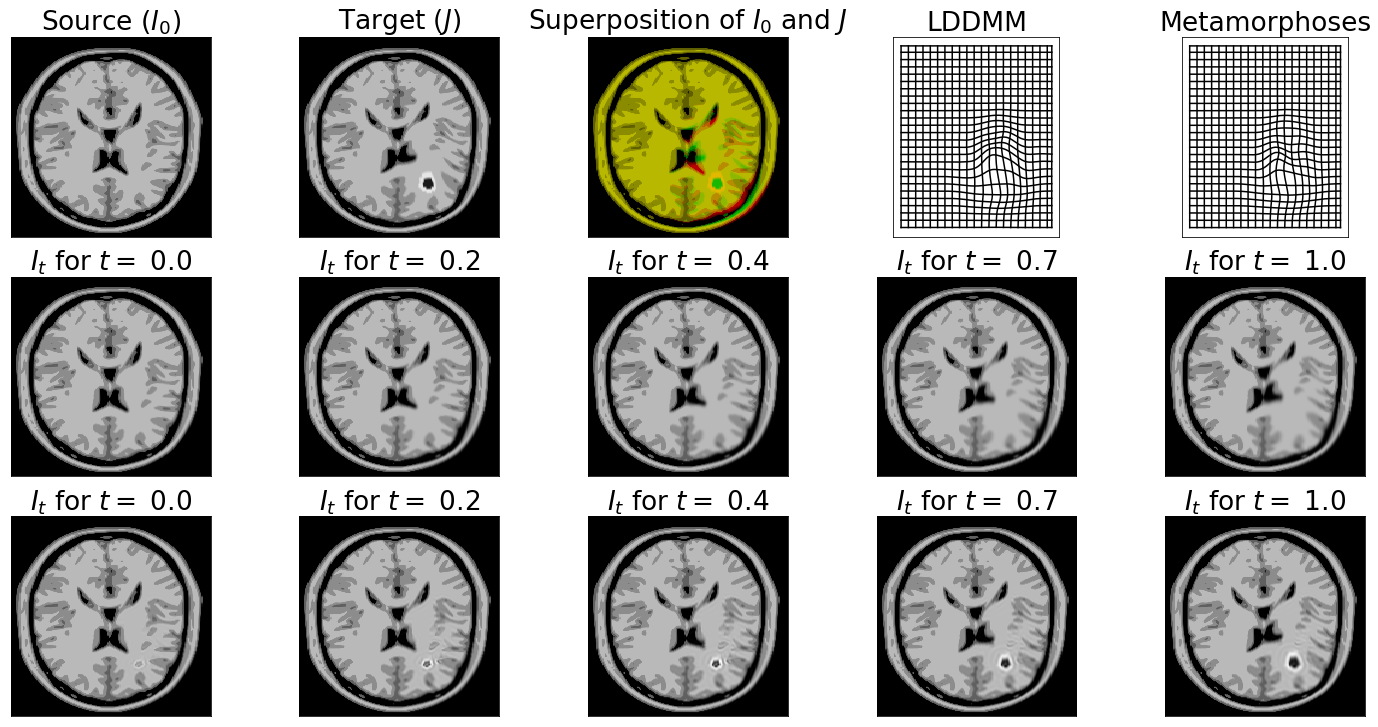

In [32]:

# Defomation computation. We compose all vectors fields from the geodesic shooting
temporal_integrator = vff.FieldIntegrator(method='temporal',save=False,dx_convention='pixel')
# Theses deformation are used for grid plotting
deformation_lddmm = temporal_integrator(mr_lddmm.mp.field_stock/n_step,forward=True)
deformation_meta = temporal_integrator(mr_meta.mp.field_stock/n_step,forward=True)

# Theses are the inverse deformation used for actual image deformation
deformator_lddmm = temporal_integrator(mr_lddmm.mp.field_stock/n_step,forward=False)
deformator_meta = temporal_integrator(mr_meta.mp.field_stock/n_step,forward=False)


 #Plot
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 22})


kw_image_args = dict(cmap='gray',
                      extent=[-1,1,-1,1],
                      origin='lower')

n_figs= 5

plot_id = torch.quantile(torch.arange(mp_lddmm.n_step,dtype=torch.float),
                                 torch.linspace(0,1,n_figs)).round().int()
# plot_id= plot_id[:-1]

cmap = 'gray'
kw_image_args = dict(cmap='gray',
                      extent=[-1,1,-1,1],
                      origin='lower',
                      vmin=0,vmax=1)

size_fig = 5
plt.rcParams['figure.figsize'] = [n_figs*size_fig,size_fig*3*5/6]
fig2,ax = plt.subplots(3,n_figs)

ax[0,0].imshow(S[0,0],**kw_image_args)
ax[0,0].set_title(r"Source ($I_0$)")
ax[0,1].imshow(T[0,0],**kw_image_args)
ax[0,1].set_title(r"Target ($J$)")
ax[0,2].imshow(tb.imCmp(S,T),**kw_image_args)
ax[0,2].set_title(r"Superposition of $I_0$ and $J$")

tb.gridDef_plot(deformation_lddmm,step=int(max(S.shape)/25),ax = ax[0,-2],
                         check_diffeo=False,title="LDDMM")
tb.gridDef_plot(deformation_meta,step=int(max(S.shape)/25),ax = ax[0,-1],
                         check_diffeo=False,title="Metamorphoses")

imcmp = False
if imcmp:
    plot_id = plot_id[:-1]
for i,t in enumerate(plot_id):
    i_1 =ax[1,i].imshow(mr_lddmm.mp.image_stock[t,0,:,:].detach().numpy(),
            **kw_image_args)
    ax[1,i].set_title(r"$I_t$ for $t =$ "+str((t/(mp_lddmm.n_step-1)).item())[:3])
    #fig2.colorbar(i_1,ax=ax[1,i],fraction=0.046, pad=0.04)

    i_3 =ax[2,i].imshow(mr_meta.mp.image_stock[t,0,:,:].detach().numpy(),
            **kw_image_args)
    ax[2,i].set_title(r"$I_t$ for $t =$ "+str((t/(mp_meta.n_step-1)).item())[:3])
    #fig2.colorbar(i_3,ax=ax[2,i],fraction=0.046, pad=0.04)

plt.setp(ax, xticks=[], yticks=[])

if imcmp:
    ax[1,-1].imshow(tb.imCmp(mr_lddmm.mp.image,T),**kw_image_args)
    ax[1,-1].set_title(r"$I_t$ for $t =1$")
    ax[2,-1].imshow(tb.imCmp(mr_meta.mp.image,T),**kw_image_args)
    ax[2,-1].set_title(r"$I_t$ for $t =1$")


In [ ]:
path = 'demeter/figs/metamorphoses/'
format = 'pdf'
fig2.savefig(path+'brain_imagesFlow_300.'+format,dpi=50,format=format,
             bbox_inches = 'tight',pad_inches = 0)

The colored images are made for comparison in between two gray scale pictures, by stacking them in
separate channels. So yellows areas are where the two images matches whereas red and green area are
the image specific ones.


